# EGL-19 Parameter Fitting

In [1]:
%matplotlib inline
import csv
import numpy as np
import math
"""
The matplotlib import is to fix an issue when running
from the Terminal in macos.  
"""
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import operator
import statistics
import time
from IPython import display
import pylab
import pandas as pd

In [2]:
# Import patch clamp data for ion channel
with open('../data/EGL-19_patch_clamp.csv', 'r') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    patch_clamp_data = np.array(list(reader))

data_range = [x[0] for x in patch_clamp_data]
data_values = [x[1] for x in patch_clamp_data]

# Plot IV curve for patch clamp experiment
def IV_scatter_plot(data):
    x, y = patch_clamp_data.T
    plt.xlabel('Membrane Potential (mV)')
    plt.ylabel('Current (pA)')
    plt.title('I/V Curve for EGL-19 Voltage-Gated Calcium Channel')
    plt.scatter(x,y)
    
# Useful namespace equivalent
ru = random.uniform

### Simulation Helper Functions

In [3]:
def i(gmax, Vhalf, k, Vrev, V): 
    """
    Define Hodgkin-Huxley ion channel model
    Put a cutoff on the argument to the exponential to prevent math overflow
    """

    diffR = V - Vrev
    diffH = Vhalf - V
    num = float(gmax)
    denom = 1 + math.exp(min(diffH/k, 700))
    return (num / denom)*diffR

def create_first_gen(n):
    """
    Generate candidate solutions
    Ranges: 
    Gmax- [0, 1]
    Vhalf- [0, 1]
    k- [0, 5]
    Vrev- [0, 70]
    """
    
    return [[ru(0,1), ru(0,1), ru(0,5), ru(0,70)] for x in range(n)]

def cost_func(m1, m2):
    """
    This is the cost function that is optimized during the simulation
    """
    
    return np.linalg.norm((np.array(m1)-np.array(m2)) / len(m1), ord=2)

def generate_test_values(params, domain):
    """
    For a given set of parameters, returns the value of the
    IV curve when evaluated on a given domain.
    """
    
    append_values = list(range(len(domain)))
    tparams = list(params)
    for n in range(0, len(domain)):
        p_temp = tparams[:4]
        p_temp.insert(4, domain[n])
        append_values[n] = p_temp
    test_values = [i(x[0], x[1], x[2], x[3], x[4]) for x in append_values]
    return test_values

def calculate_norm(params, time_series):
    """
    *Should refactor make use of generate_test_values- repeated code here.*
    Returns the cost function when applied to the IV curve
    of a candidate solution with respect to the measured
    values from the patch clamp data imported above.
    """
    
    append_values = list(range(len(data_range)))
    tparams = list(params)
    for n in range(0, len(data_range)):
        p_temp = tparams[:4]
        p_temp.insert(4, data_range[n])
        append_values[n] = p_temp
    test_values = [i(x[0], x[1], x[2], x[3], x[4]) for x in append_values]
    return cost_func(test_values, data_values)

def generate_parameter_space(p_gen, time_series):
    """
    This is only used after adaptive sampling has started.
    First, the best scoring candidate from all previous generations
    is determined.  Then, the random Gaussian drift function
    is repeatedly applied to the best candidate until the
    entire population is filled out. 
    """
    
    all_norms = [[x, calculate_norm(x, time_series)] for x in p_gen]
    all_norms.sort(key=operator.itemgetter(1))
    best_candidate = all_norms[0][0]
    return [list(map(random_gaussian_drift, best_candidate)) for x in range(pop_size)]

### Mutation Operators

In [4]:
"""
Mutations operators:
1) Random mutation over the parameter space
2) Random Guassian drift centered around current value with 5% variance
3) Crossover: randomly pick an index and swap the values between two organisms
"""

track_mutations = [] #Append to this list the type of mutation operator that was applied

def random_mutation(x, n):
    """
    Recall that the parameter space is different for each coordinate:
    Gmax- [0, 1]
    Vhalf- [0, 1]
    k- [0, 5]
    Vrev- [0, 70]
    """
    
    choices = {0: ru(0,1), 1: ru(0,1), 2: ru(0,5), 3: ru(0,70)}
    return choices[n]

def random_gaussian_drift(x):
    """
    This is used both as a mutation operator and also for adaptive sampling
    """
    return np.random.normal(x, .05*x)

def mutate(x, n):
    """
    1% probability of any given mutation.  
    Flip a coin to decide if it is a random mutation or a Gaussian drift
    The second argument is needed for when a random_mutation is applied (see above)
    """
    
    mbool = ru(0,1) < .01
    if mbool:
        if bool(random.getrandbits(1)):
            track_mutations.append('Random Mutation')
            return random_mutation(x,n)
        else: 
            track_mutations.append('Random Guassian Drift')
            return random_gaussian_drift(x)
    else: 
        return x

def one_point_swap(list1, list2, n):
    """
    This is just a helper function for the crossover operator
    """
    
    tlist1 = list(list1)
    tlist2 = list(list2)
    temp = tlist1[n]
    tlist1[n] = tlist2[n]
    tlist2[n] = temp
    return tlist1, tlist2

def random_crossover(list1, list2):
    """
    Given two lists, pick a random index and swap the corresponding entries
    """
    
    mbool = ru(0,1) < .5
    if mbool: 
        pos = random.randint(0,3)
        track_mutations.append('Crossover at ' + str(pos))
        return one_point_swap(list1, list2, pos)
    else:
        return list1, list2

def check_threshold(sim_hist):
    """
    Used to determine when to end the simulation
    """
   
    if len(sim_hist) < 2:
        return 1
    else:
        return statistics.variance(sim_hist[-t_win:])

### Display Functions

In [104]:
def display_fit(candidate):
    """
    Summarizes simulation results.  
    """
    x,y = list(range(-40,80,1)), generate_test_values(candidate, list(range(-40,80,1)))
    pylab.plot(x,y)
    a, b = patch_clamp_data.T
    plt.scatter(a,b)
    plt.xlabel('Membrane Potential (mV)')
    plt.ylabel('Current (pA)')
    plt.title('I/V Curve for EGL-19 Voltage-Gated Calcium Channel')
    return pd.DataFrame(candidate, index=["Gmax", "Vh", "k", "Vrev"], columns=['Candidate Solution'])

def make_grid(current_round, norm_values, live_updates=False):
    """
    This is updated dynamically during the simulation to display the 
    simulation trajectory. 
    """
    
    print("Current Round: ", current_round)
    fig, ax = plt.subplots(dpi=200)
    ax.plot(range(1,len(norm_values)+1), norm_values)
    ax.set_ylim(0, max(norm_values))
    ax.set_xlim(1, len(norm_values)+1)
    ax.annotate('Adaptive Sampling', 
            xy=(start_AS, -0.01), 
            xytext=(start_AS, -2),
            arrowprops = dict(facecolor='black', shrink=.1))
    plt.xlabel('Number of Generations')
    plt.ylabel('Fitness of Best Solution')
    plt.title('Simulation History')
    if live_updates:
        display.clear_output(wait=True)
        plt.show()

def display_parameter_evolution(all_survivor_params):
    """
    Show how parameters changed across generations.
    Takes the lists of parameters for all winning solutions.
    """
    fig, ax = plt.subplots(nrows=2, ncols=2, dpi=100)
    plt.tight_layout()

    ax[0][0].set_title('$G_{max}$')
    ax[0][0].hist([x[0] for x in all_survivor_params])

    ax[0][1].set_title('$V^{1/2}$')
    ax[0][1].hist([x[1] for x in all_survivor_params])

    ax[1][0].set_title('k')
    ax[1][0].hist([x[2] for x in all_survivor_params])

    ax[1][1].set_title('$V_{rev}$')
    ax[1][1].hist([x[3] for x in all_survivor_params])
    plt.show()



### Core Simulation Functions

In [105]:
def ion_channel_fit(time_series):
    global running_tally
    global num_rounds
    global start_AS
    global living
    global norms
    global all_orgs
    global total_solutions
    global running_tally
    global new_parameter_space
    global temp
    num_rounds  = 0
    start_AS = 1000
    living = []
    norms = []
    all_orgs = []
    total_solutions = 0
    running_tally = []
    
    while(num_rounds < 200):
        """
        while(check_threshold(running_tally) > math.pow(10,-4)):
        The simulation seems to converge quickly enough that fixed
        number of rounds is sufficient to guarantee a reasonably good fit.  
        """
    
        num_rounds = num_rounds + 1
        
        """
            1) Set the parameter space / "organisms" for the current round.
            2) Reset the list $living{} so that the current surviving organisms will be added to it.
            3) Calculate all the norms of the current set.  Sort, and retain the highest scoring individual.
            4) After start_AS, use the adaptive sampling procedure to generate populations.  
        """

        if num_rounds == 1:
            new_parameter_space = create_first_gen(100)
        elif 2 <= num_rounds <= start_AS:
            new_parameter_space = living        
        else:
            new_parameter_space = generate_parameter_space(living, time_series)

        """
        This next section simply ensures that the highest scoring individual
        is always retained in each round.
        """
        round_length = round(len(new_parameter_space) / 2)
        living = []
        temp = [[x, calculate_norm(x, time_series)] for x in new_parameter_space]
        temp.sort(key=operator.itemgetter(1))
        norms = temp
        living.append(norms[0][0])
        all_orgs.append(norms[0][0])
        running_tally.append(norms[0][1])

        """
        Begin inner loop:
        This is the tournament where solutions compete against one another
        """
        for n in range(1, round_length+1):
            pair1, pair2 = random.sample(norms,2), random.sample(norms,2)
            pair1.sort(key=operator.itemgetter(1))
            pair2.sort(key=operator.itemgetter(1))
            survivor1 = pair1[0][0]
            survivor2 = pair2[0][0]
            [living.append(x) for x in random_crossover(survivor1, survivor2)]
        
        # End inner loop

        # Apply mutation operators to population
        global temp_living
        temp_living = []
        for n in range(0, len(living)-1):
            temp_living.append([mutate(x,n) for n,x in enumerate(living[n])])

        living = temp_living
        total_solutions += len(living)
        
        # Summary grid for current round
        make_grid(num_rounds, running_tally, True)

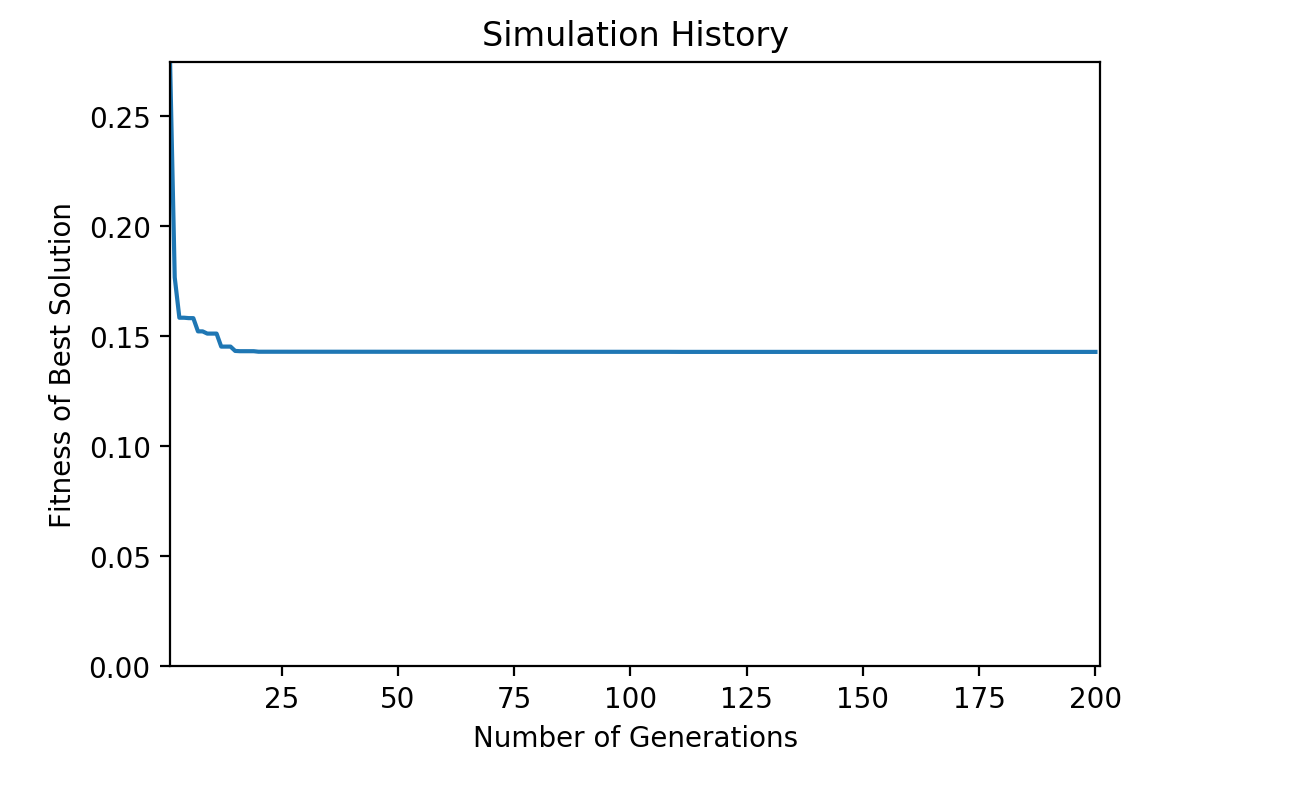

In [30]:
ion_channel_fit(patch_clamp_data)

,Candidate Solution
Gmax,0.176102
Vh,0.757471
k,4.626956
Vrev,52.367909


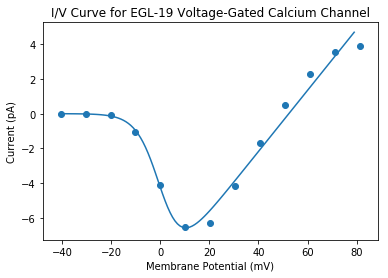

In [32]:
display_fit(norms[0][0])

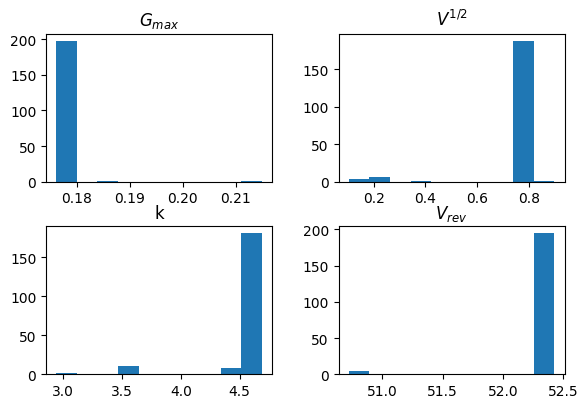

In [106]:
display_parameter_evolution(all_orgs)

In [43]:
"""
This is just here for when the notebook is converted to a 
standalone script for the purpose of running the doc tests.
"""
if __name__ == "__main__":
    import doctest
    doctest.testmod()